## Lactate Discordance Project: Exploratory Analysis of Lactate in MIMIC-III by Illness Severity
### C.V. Cosgriff, MIT Critical Data

This notebook extracts the maximum lactate in the first 24 hours for all patients in the MIMIC-III. After excluding patients with length of stay below four hours, those lacking data, and those under the age of 16, the lactate levels are grouped using deciles of the OASIS score and then the distribution is plotted.

__Updated 5/3/2019:__ Following the initial analysis described above, the use of vasopressors and invasive ventilation were examined in the top decile of the OASIS score stratified by normality of lactate. The analysis has also been edited to only include metavision data.

## 0 - Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path TO ' + schema_name + ';'

con = psycopg2.connect(dbname=dbname)

## 1 - Initial Extraction

Extract data from SQL database. Note we're using `labsfirstday`, `icustay_detail`, and `OASIS` materialized view. We also limit our cohort to patients from metavision.

In [2]:
query = query_schema + '''
SELECT ied.icustay_id, ied.admission_age, la.lactate_max
       , os.oasis, ied.los_icu, ied.hospital_expire_flag         
FROM icustay_detail ied
LEFT JOIN labsfirstday la
    ON ied.icustay_id = la.icustay_id
INNER JOIN oasis os
    ON ied.icustay_id = os.icustay_id
LEFT JOIN icustays ie
    ON ied.icustay_id = ie.icustay_id
WHERE ie.dbsource = 'metavision';
'''

base_cohort = pd.read_sql_query(query, con)
display(base_cohort.head())
print(base_cohort.shape)

,icustay_id,admission_age,lactate_max,oasis,los_icu,hospital_expire_flag
0,234044,75.2564,4.6,24,1.1862,0
1,290505,304.6041,1.7,40,1.5824,0
2,241249,72.7284,1.0,23,4.3483,0
3,291697,76.8498,0.9,35,1.9909,0
4,264253,70.1147,NaN,33,1.9313,0


(23582, 6)


Limit cohort to those who have a lactate, an OASIS score, are age >16, and have a LoS greater than 4 hours.

In [3]:
base_cohort.loc[base_cohort.admission_age >= 90, 'admission_age'] = 91.3

include = (base_cohort.loc[:, 'admission_age']) > 16
include = include & (~pd.isna(base_cohort.loc[:, 'oasis']))
include = include & (~pd.isna(base_cohort.loc[:, 'lactate_max']))
incldue = include & (base_cohort.loc[:, 'los_icu'] >= 0.167)
cohort = base_cohort.loc[include, ['icustay_id', 'oasis', 'lactate_max']]

## 2 - Initial Lactate vs. OASIS Analysis

We then create deciles of the APACHE IVa score and assign each patient stay to a category. 

In [4]:
oasis_category = pd.qcut(x=cohort.oasis, q=np.arange(0, 1.1, 0.1), labels=np.arange(1, 11, 1))
cohort = cohort.assign(oasis_category=oasis_category)
cohort.loc[:, ['oasis_category', 'lactate_max']].groupby('oasis_category').describe()

lactate_max                                              
                     count      mean       std  min  25%  50%  75%   max
oasis_category                                                          
1                   1692.0  2.209102  1.691030  0.5  1.2  1.8  2.6  19.5
2                   2033.0  2.397639  1.621295  0.3  1.4  2.0  2.9  13.1
3                   1334.0  2.401649  1.589858  0.5  1.4  2.0  2.9  18.8
4                   1364.0  2.425572  1.882850  0.5  1.4  2.0  2.9  27.7
5                   2060.0  2.618641  1.927040  0.4  1.4  2.1  3.1  19.9
6                   1370.0  2.638613  1.866135  0.3  1.4  2.1  3.2  19.0
7                   1755.0  2.834644  2.178695  0.5  1.5  2.2  3.3  22.6
8                   1410.0  2.837801  2.271141  0.4  1.5  2.2  3.3  21.7
9                   1311.0  3.212281  2.700892  0.4  1.6  2.4  3.9  32.0
10                  1482.0  4.184413  3.605822  0.5  1.7  2.9  5.3  25.1

We can plot the above distributions.

/home/cvc/env/ML/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/cvc/env/ML/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Distribution of Maximum Lactate on Day 1, Grouped by OASIS Decile')

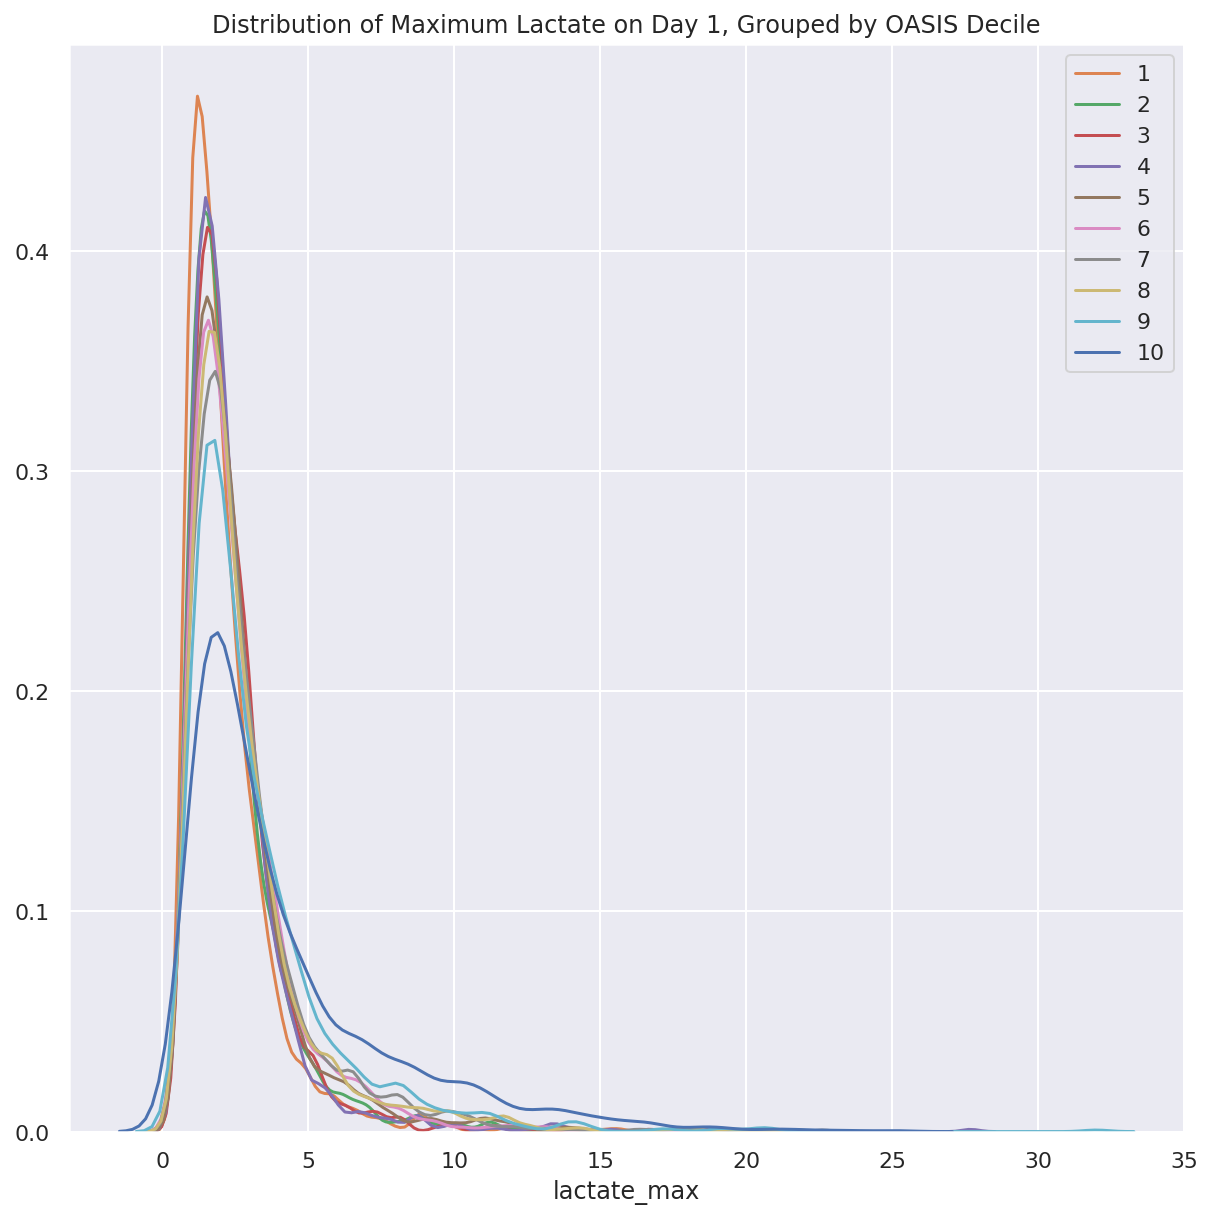

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
for i in range(11):
    sns.distplot(cohort.loc[cohort.oasis_category == i, 'lactate_max'], hist=False, ax=ax, label=i)
plt.legend()
plt.title('Distribution of Maximum Lactate on Day 1, Grouped by OASIS Decile')

We can also answer the question, "within each decile, how many patient's have a _normal_ lactate?"

Text(0, 0.5, 'Proportion with Normal Lactate')

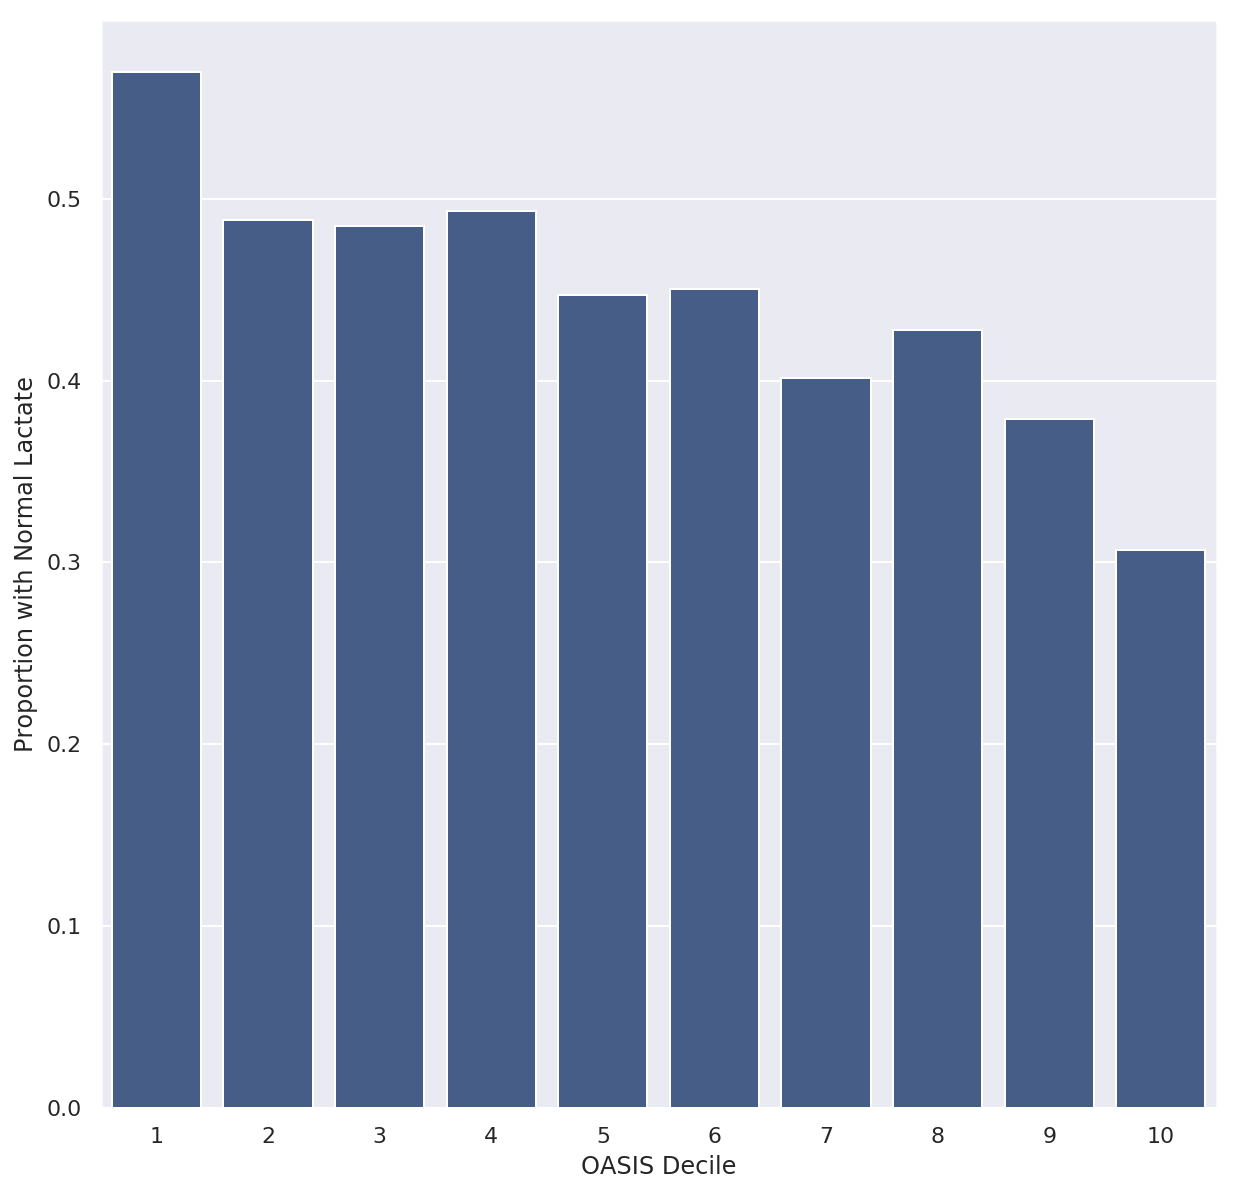

In [6]:
def normal_lactate(x):
    return (x < 2).mean()

normal_lac_prop = [normal_lactate(cohort.loc[cohort.oasis_category == i, 'lactate_max']) for i in range(1,11)]

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.barplot(x=np.arange(1,11), y=normal_lac_prop, color=sns.xkcd_rgb['denim blue'], ax=ax)
plt.xlabel('OASIS Decile')
plt.ylabel('Proportion with Normal Lactate')

## 3 - Brief Exploration of ICU Treatment Differences

After presenting the above data to the Leo and the group the next steps for the analysis were decided below.

__Focusing on day 1 as above extract these and examine in the top decile of OASIS:__
* Vasopressor dose
* Count of vasopressors
* MV 0/1

There exists materialized views for the different vasoproessor doses. We will want to use these views to get the total dose of vasopressor on the first day in the ICU for each drug listed here:
* Dopamine
* Epinephrine
* Norepinephrine
* Phenylephrine
* Vasopressin

Once we have the amount of each in the first day we can count the number of different vasopressors used on day 1. At our next meeting we will discuss conversion to a common metric if that is necessary. 

In [7]:
query = query_schema + '''
WITH vasopressor_dose AS (
    SELECT ie.icustay_id
    , SUM(nd.vaso_amount) AS norepi_dose -- total daily doses in mg
    , SUM(pe.vaso_amount) AS phenyl_dose
    , SUM(da.vaso_amount) AS dopa_dose
    , SUM(ep.vaso_amount) AS epi_dose
    , SUM(vp.vaso_amount) AS vaso_dose
    FROM icustays ie
    LEFT JOIN norepinephrine_dose nd
        ON ie.icustay_id = nd.icustay_id
        AND ie.intime - interval '4' hour < nd.starttime
        AND ie.intime + interval '28' hour > nd.endtime
    LEFT JOIN phenylephrine_dose pe
        ON ie.icustay_id = pe.icustay_id
        AND ie.intime - interval '4' hour < pe.starttime
        AND ie.intime + interval '28' hour > pe.endtime
    LEFT JOIN dopamine_dose da
        ON ie.icustay_id = da.icustay_id
        AND ie.intime - interval '4' hour < da.starttime
        AND ie.intime + interval '28' hour > da.endtime
    LEFT JOIN epinephrine_dose ep
        ON ie.icustay_id = ep.icustay_id
        AND ie.intime - interval '4' hour < ep.starttime
        AND ie.intime + interval '28' hour > ep.endtime
    LEFT JOIN vasopressin_dose vp
        ON ie.icustay_id = vp.icustay_id
        AND ie.intime - interval '4' hour < vp.starttime
        AND ie.intime + interval '28' hour > vp.endtime
    GROUP BY ie.icustay_id
)
SELECT vd.*, mv.vent
FROM vasopressor_dose vd
LEFT JOIN ventfirstday mv
    ON vd.icustay_id = mv.icustay_id;
'''

intervention_df = pd.read_sql_query(query, con)
print(intervention_df.shape)
display(intervention_df.head())
display(intervention_df.dropna().head())

(61532, 7)


,icustay_id,norepi_dose,phenyl_dose,dopa_dose,epi_dose,vaso_dose,vent
0,200001,NaN,NaN,NaN,NaN,NaN,0
1,200003,NaN,3.08,NaN,NaN,NaN,1
2,200006,NaN,NaN,NaN,NaN,NaN,1
3,200007,NaN,NaN,NaN,NaN,NaN,0
4,200009,NaN,NaN,NaN,NaN,NaN,1


,icustay_id,norepi_dose,phenyl_dose,dopa_dose,epi_dose,vaso_dose,vent
2943,204715,2.457000,65.280000,327.200000,0.828100,12.200000,1
5599,209051,13.333334,71.428576,799.999966,2.607143,1.200000,0
6089,209826,19.009509,186.826359,634.000004,5.555941,20.000000,1
11589,218732,357.383914,2399.621060,63.854050,51.150684,1259.834383,1
23370,237924,151.091171,678.325349,7429.157427,12.812501,955.999976,1


As many patients will not have all or any of these medications, lets visualize the pattern of missingness for this data.

icustay_id     61532
norepi_dose     5097
phenyl_dose     8539
dopa_dose       2527
epi_dose        1473
vaso_dose        757
vent           61532
dtype: int64

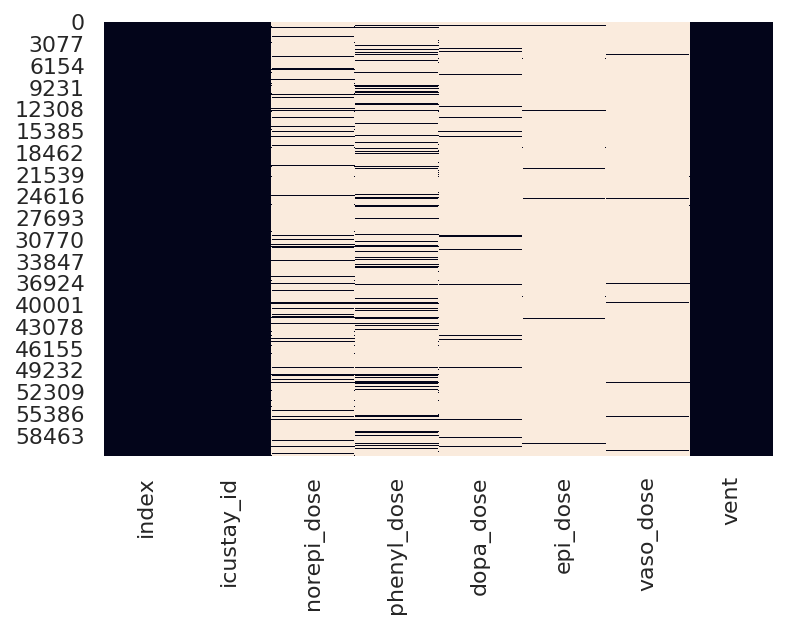

In [8]:
sns.heatmap(intervention_df.reset_index().isna(), cbar=False)
(~pd.isna(intervention_df)).sum()

Careful evaluation of our code doesn't suggest an obvious error, but it is strange that norepinephrine is used less than phenylephrine, and doesn't quite square with our domain knowledge. This also just may reflect older practice.

Next we'll count the number of vasopressors present for each patient/icustay_id and then merge it with the cohort from above.

In [9]:
pressor_count = intervention_df.drop(['icustay_id', 'vent'], axis=1).apply(lambda x: x.count(), axis=1)
intervention_df = intervention_df.assign(pressor_count=pressor_count)
cohort = cohort.merge(right=intervention_df, how='left', on='icustay_id')
print(cohort.shape)
display(cohort.head())

(15811, 11)


,icustay_id,oasis,lactate_max,oasis_category,norepi_dose,phenyl_dose,dopa_dose,epi_dose,vaso_dose,vent,pressor_count
0,234044,24,4.6,2,NaN,NaN,NaN,NaN,NaN,0,0
1,290505,40,1.7,8,NaN,NaN,NaN,NaN,NaN,1,0
2,241249,23,1.0,2,NaN,NaN,NaN,NaN,NaN,1,0
3,291697,35,0.9,6,NaN,NaN,NaN,NaN,NaN,0,0
4,252542,23,1.8,2,NaN,NaN,NaN,NaN,NaN,0,0


Now that we have merged, we have limited our vasopressor information to the metavision patients; lets repeat the examination of missingness to see if norepinephrine is more common in this recent cohort.

icustay_id        15811
oasis             15811
lactate_max       15811
oasis_category    15811
norepi_dose        2206
phenyl_dose        3523
dopa_dose           560
epi_dose            611
vaso_dose           302
vent              15811
pressor_count     15811
dtype: int64

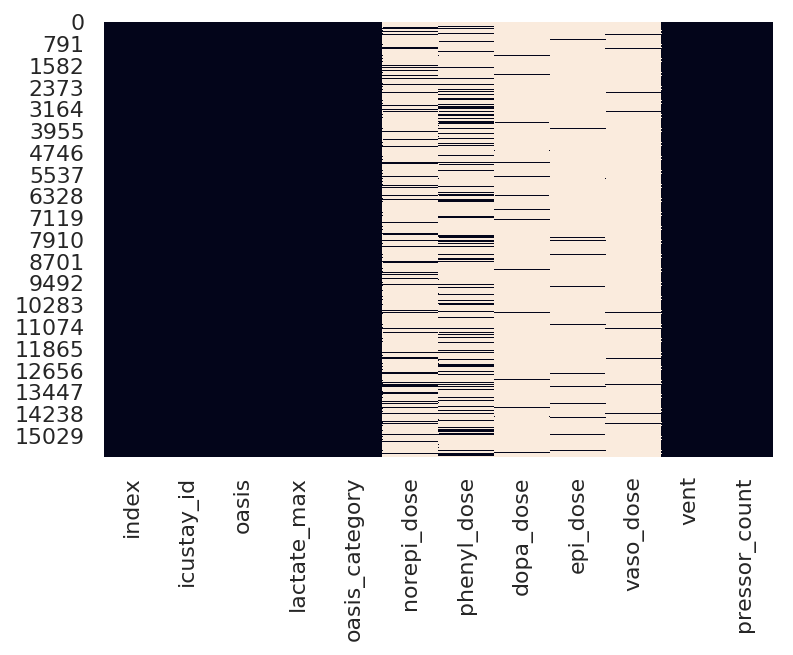

In [10]:
sns.heatmap(cohort.reset_index().isna(), cbar=False)
(~pd.isna(cohort)).sum()

Still a bit more patient's with phenylephrine doses. This data is up until 2012, but we'll have to carefully review our code. 

For now we'll go forward and limit our analysis to the top decile of OASIS.

In [11]:
eda_df = cohort.loc[cohort.oasis_category == 10, :].copy()
print(eda_df.shape)
display(eda_df.head())

(1482, 11)


,icustay_id,oasis,lactate_max,oasis_category,norepi_dose,phenyl_dose,dopa_dose,epi_dose,vaso_dose,vent,pressor_count
17,249202,59,5.5,10,12.780800,240.000008,NaN,4.363502,26.733378,1,4
18,256064,46,1.3,10,NaN,39.209069,NaN,NaN,NaN,1,1
20,213646,46,1.7,10,NaN,NaN,NaN,NaN,NaN,1,0
23,284015,53,3.2,10,0.903213,13.102587,NaN,NaN,NaN,1,2
41,209737,52,1.1,10,15.929123,56.142602,NaN,NaN,99.399998,1,3


For exploring this data it will be useful to have a binary indiactor for _normal_ lactate (<2, as above).

In [12]:
normal_lactate = (eda_df.lactate_max < 2).astype(int)
eda_df = eda_df.assign(normal_lactate=normal_lactate)

We then plot the vasopressor count and stratify by whether or not lactate levels were normal.

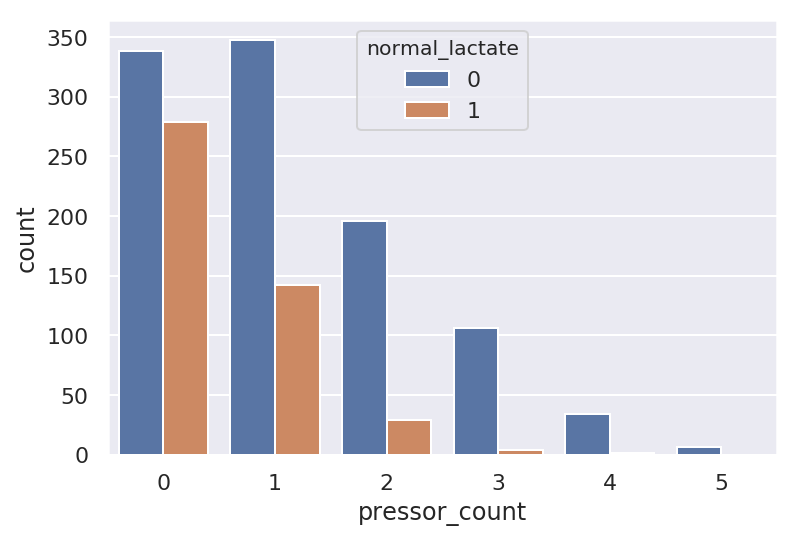

In [13]:
sns.countplot(x='pressor_count', hue='normal_lactate', data=eda_df)

Patients with normal lactate received far less vasopressor therapy. It is curious why a patient with a maximum lactate of 2 would recieve any vasopressors, but these patients were also very sick. Perhaps these represent true non-responders; however, it is too soon to draw a conclusion and next steps may be to examine these patients more closely.

Similarly, we can plot ventilation status on the first day against the lactate level.

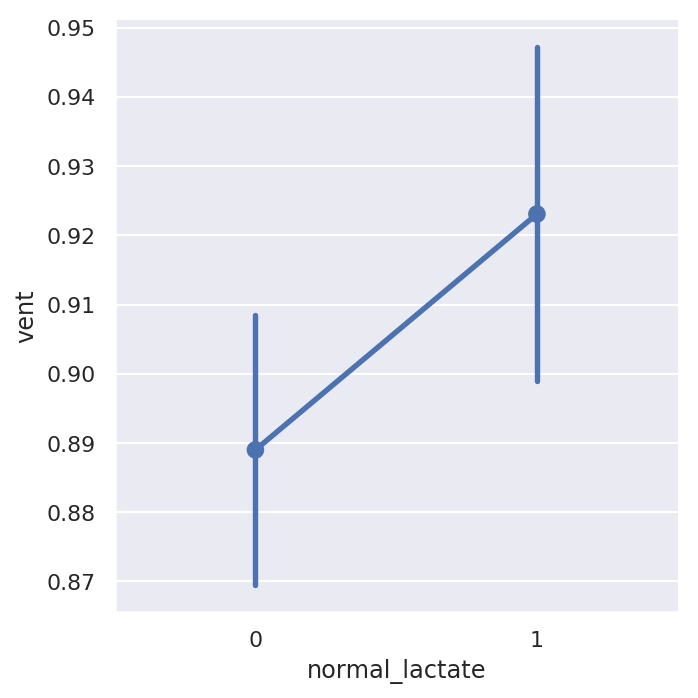

In [14]:
sns.catplot(x='normal_lactate', y='vent', kind='point', data=eda_df)

Essentially everyone in both groups is ventilated. 

Before concluding, we can visualize the difference in total dose of each vasopressor between groups, however, we expect the dose to be higher in the patients with elevated lactate across the board.

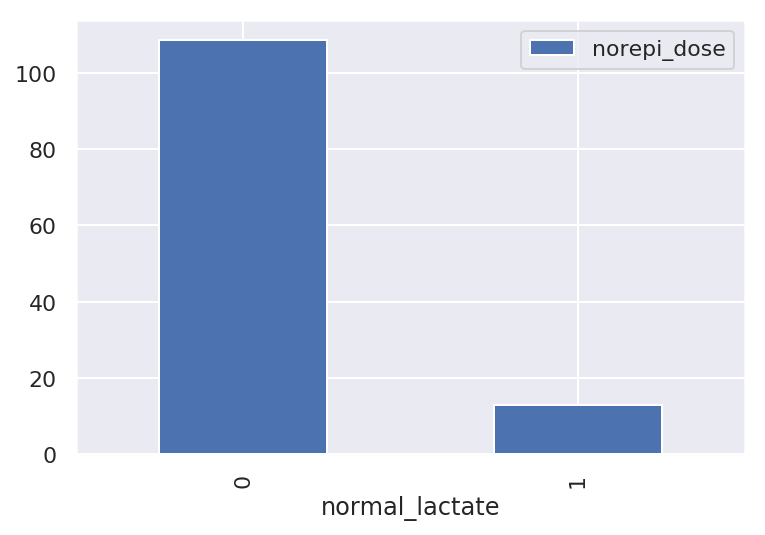

In [15]:
eda_df.groupby('normal_lactate').mean().loc[:, ['norepi_dose']].plot(kind='bar')

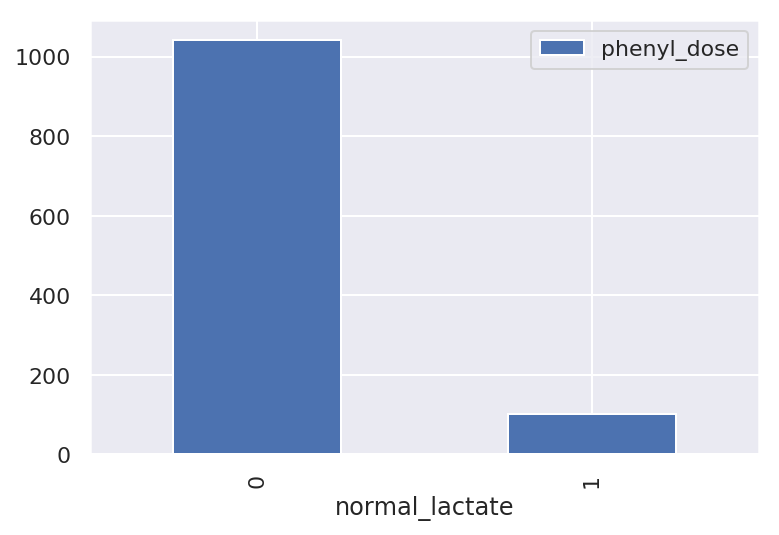

In [16]:
eda_df.groupby('normal_lactate').mean().loc[:, ['phenyl_dose']].plot(kind='bar')

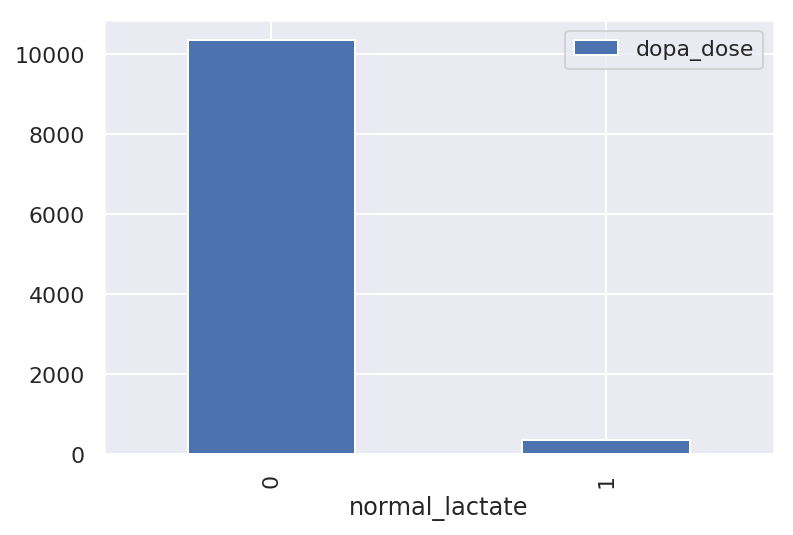

In [17]:
eda_df.groupby('normal_lactate').mean().loc[:, ['dopa_dose']].plot(kind='bar')

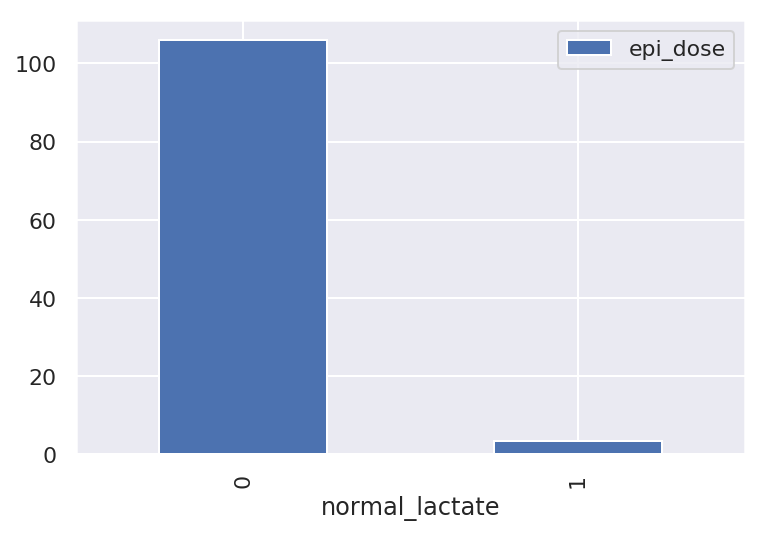

In [18]:
eda_df.groupby('normal_lactate').mean().loc[:, ['epi_dose']].plot(kind='bar')

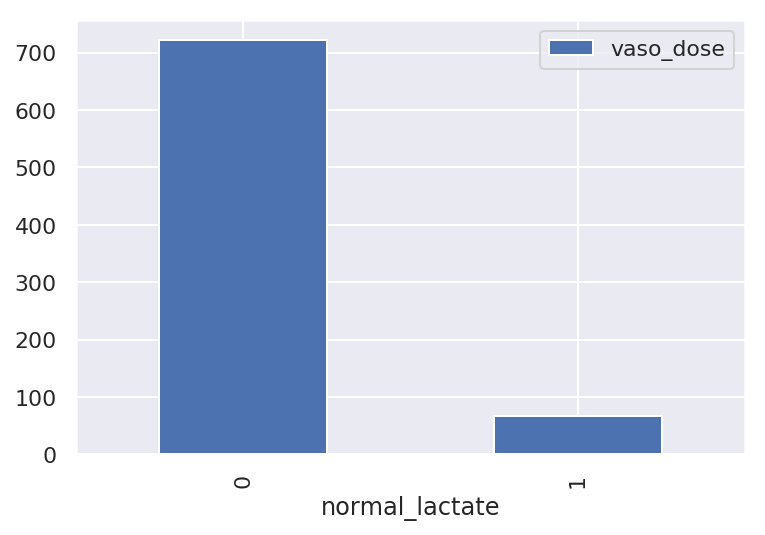

In [19]:
eda_df.groupby('normal_lactate').mean().loc[:, ['vaso_dose']].plot(kind='bar')

The upshot in this analysis so far is that at the top decile of OASIS score, virtually everyone is vented, and those with normal lactate appear to be recieving far less vasopressor therapy. The patients with normal lactates recieving single, and even double pressor therapy in the ICU are a curious bunch, and may represent so called non-responders, but more work is needed.